In [1]:
from ctypes import *
import math
import random

def sample(probs):
    s = sum(probs)
    probs = [a/s for a in probs]
    r = random.uniform(0, 1)
    for i in range(len(probs)):
        r = r - probs[i]
        if r <= 0:
            return i
    return len(probs)-1

def c_array(ctype, values):
    arr = (ctype*len(values))()
    arr[:] = values
    return arr

class BOX(Structure):
    _fields_ = [("x", c_float),
                ("y", c_float),
                ("w", c_float),
                ("h", c_float)]

class DETECTION(Structure):
    _fields_ = [("bbox", BOX),
                ("classes", c_int),
                ("prob", POINTER(c_float)),
                ("mask", POINTER(c_float)),
                ("objectness", c_float),
                ("sort_class", c_int)]


class IMAGE(Structure):
    _fields_ = [("w", c_int),
                ("h", c_int),
                ("c", c_int),
                ("data", POINTER(c_float))]

class METADATA(Structure):
    _fields_ = [("classes", c_int),
                ("names", POINTER(c_char_p))]
    
#lib = CDLL("/home/pjreddie/documents/darknet/libdarknet.so", RTLD_GLOBAL)
lib = CDLL("/raid6/home/ramraj/ACADEMICS/BioImageAnalysis-2020Spring/darknet/libdarknet.so", RTLD_GLOBAL)
lib.network_width.argtypes = [c_void_p]
lib.network_width.restype = c_int
lib.network_height.argtypes = [c_void_p]
lib.network_height.restype = c_int

predict = lib.network_predict
predict.argtypes = [c_void_p, POINTER(c_float)]
predict.restype = POINTER(c_float)

set_gpu = lib.cuda_set_device
set_gpu.argtypes = [c_int]

make_image = lib.make_image
make_image.argtypes = [c_int, c_int, c_int]
make_image.restype = IMAGE

get_network_boxes = lib.get_network_boxes
get_network_boxes.argtypes = [c_void_p, c_int, c_int, c_float, c_float, POINTER(c_int), c_int, POINTER(c_int)]
get_network_boxes.restype = POINTER(DETECTION)

make_network_boxes = lib.make_network_boxes
make_network_boxes.argtypes = [c_void_p]
make_network_boxes.restype = POINTER(DETECTION)

free_detections = lib.free_detections
free_detections.argtypes = [POINTER(DETECTION), c_int]

free_ptrs = lib.free_ptrs
free_ptrs.argtypes = [POINTER(c_void_p), c_int]

network_predict = lib.network_predict
network_predict.argtypes = [c_void_p, POINTER(c_float)]

reset_rnn = lib.reset_rnn
reset_rnn.argtypes = [c_void_p]

load_net = lib.load_network
load_net.argtypes = [c_char_p, c_char_p, c_int]
load_net.restype = c_void_p

do_nms_obj = lib.do_nms_obj
do_nms_obj.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

do_nms_sort = lib.do_nms_sort
do_nms_sort.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

free_image = lib.free_image
free_image.argtypes = [IMAGE]

letterbox_image = lib.letterbox_image
letterbox_image.argtypes = [IMAGE, c_int, c_int]
letterbox_image.restype = IMAGE

load_meta = lib.get_metadata
lib.get_metadata.argtypes = [c_char_p]
lib.get_metadata.restype = METADATA

load_image = lib.load_image_color
load_image.argtypes = [c_char_p, c_int, c_int]
load_image.restype = IMAGE

rgbgr_image = lib.rgbgr_image
rgbgr_image.argtypes = [IMAGE]

predict_image = lib.network_predict_image
predict_image.argtypes = [c_void_p, IMAGE]
predict_image.restype = POINTER(c_float)

In [2]:
def detect(net, meta, image, thresh=.5, hier_thresh=.5, nms=.45):
    im = load_image(image, 0, 0)
    num = c_int(0)
    pnum = pointer(num)
    predict_image(net, im)
    dets = get_network_boxes(net, im.w, im.h, thresh, hier_thresh, None, 0, pnum)
    num = pnum[0]
    if (nms): do_nms_obj(dets, num, meta.classes, nms);

    res = []
    for j in range(num):
        for i in range(meta.classes):
            if dets[j].prob[i] > 0:
                b = dets[j].bbox
                res.append((meta.names[i], dets[j].prob[i], (b.x, b.y, b.w, b.h)))
    res = sorted(res, key=lambda x: -x[1])
    free_image(im)
    free_detections(dets, num)
    return res

# Load YOLO-V2 trained on PASCAL-VOC

In [3]:
# # net = load_net(b"cfg/yolov3.cfg", b"yolov3.weights", 0)
# net = load_net(b"cfg/yolov2-voc.cfg", b"yolov2.weights", 0)
# meta = load_meta(b"cfg/voc.data")

net = load_net(b"cfg/yolov2-voc.cfg", b"yolov2-voc.weights", 0)
meta = load_meta(b"cfg/voc.data")
r = detect(net, meta, b"data/dog.jpg")
print(r)

[(b'dog', 0.908364474773407, (226.09542846679688, 365.95867919921875, 186.68927001953125, 294.5250244140625)), (b'car', 0.8651756048202515, (578.2688598632812, 121.9164047241211, 232.78802490234375, 97.83444213867188)), (b'bicycle', 0.814599335193634, (334.7672119140625, 250.7566680908203, 486.9348449707031, 323.4674377441406))]


# Predict

In [59]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from scipy.optimize import linear_sum_assignment
from collections import defaultdict
import os
import time
import datetime

In [60]:
IMAGE_DIR = "/raid6/home/ramraj/ACADEMICS/BioImageAnalysis-2020Spring/VOCdevkit/VOC2010/JPEGImages/"

ANNOT_DIR = "/raid6/home/ramraj/ACADEMICS/BioImageAnalysis-2020Spring/VOCdevkit/VOC2010/Annotations/"

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


# val_image_file = "/raid6/home/ramraj/ACADEMICS/BioImageAnalysis-2020Spring/VOCdevkit/VOC2010/ImageSets/Layout/val.txt"
val_image_file = "/raid6/home/ramraj/ACADEMICS/BioImageAnalysis-2020Spring/VOCdevkit/VOC2010/ImageSets/Main/val.txt"

val_image_list_data = open(val_image_file, 'r').read().strip().split('\n')
# val_image_list = [e.split(' ')[0] for e in val_image_list_data]
val_image_list = [e for e in val_image_list_data]
print(len(val_image_list))

THRESH_IOU = 0.5

def format_time(elapsed_time):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed_time)))
    return str(datetime.timedelta(seconds=elapsed_rounded)) # Format as hh:mm:ss

5105


In [64]:
yolo2_outputs_all = defaultdict()

time_list = []
time_formatted_list = []

total_t0 = time.time()

for idx, img_name in enumerate(val_image_list):
    t0 = time.time()
    
    img_path = os.path.join(IMAGE_DIR, "%s.jpg" % img_name)
    img_path = bytes(img_path, 'utf-8')
    
    r = detect(net, meta, img_path)
    yolo2_outputs_all[img_name] = r
        
    t1 = time.time() - t0
    t1f = format_time(t1)
    time_list.append(t1)
    time_formatted_list.append(t1f)
    
    if idx % 500 == 0: print("Finished : ", idx)

        
print("Total time took {:} (h:mm:ss) for {} number of images".format(format_time(time.time() - total_t0), len(val_image_list)))

Finished :  0
Finished :  500
Finished :  1000
Finished :  1500
Finished :  2000
Finished :  2500
Finished :  3000
Finished :  3500
Finished :  4000
Finished :  4500
Finished :  5000
Total time took 0:02:14 (h:mm:ss) for 5105 number of images


In [66]:
time_list[:10], time_formatted_list[:10]

([0.05211758613586426,
  0.029529094696044922,
  0.029924631118774414,
  0.03239130973815918,
  0.030046701431274414,
  0.030774354934692383,
  0.030102252960205078,
  0.0327911376953125,
  0.032057762145996094,
  0.027157306671142578],
 ['0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00'])

In [68]:
preds_map = defaultdict()

pred_class_set = set()

for img_id, yolo_res in yolo2_outputs_all.items():
    
    pred_class_objs_map = defaultdict(list)
    
    for obj in yolo_res:
        clss_name = obj[0].decode("utf-8") 
        bbox = obj[2] # [X, Y, width, height]
        
        reformatted_box = [bbox[0] - int(bbox[2]/2), bbox[1] - int(bbox[3]/2), bbox[2], bbox[3]]
        pred_class_objs_map[clss_name].append(reformatted_box)
        pred_class_set.add(clss_name)
    
    preds_map[img_id] = pred_class_objs_map
    
# 2008_000223
pred_class_set, len(pred_class_set)

({'aeroplane',
  'bicycle',
  'bird',
  'boat',
  'bottle',
  'bus',
  'car',
  'cat',
  'chair',
  'cow',
  'diningtable',
  'dog',
  'horse',
  'motorbike',
  'person',
  'pottedplant',
  'sheep',
  'sofa',
  'train',
  'tvmonitor'},
 20)

# Read Ground truth data (bounding boxes)

In [69]:
def load_ground_truth(image_id):
    
    annot_path = os.path.join(ANNOT_DIR, "%s.xml" % image_id)
    
    tree=ET.parse(annot_path)
    root = tree.getroot()
    
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    
    return_class_objs_map = defaultdict(list)
    
    cnt = 0
    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        # cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        
        x_min = int( float(xmlbox.find('xmin').text) )
        x_max = int( float(xmlbox.find('xmax').text) )
        y_min = int( float(xmlbox.find('ymin').text) )
        y_max = int( float(xmlbox.find('ymax').text) )
        
        # return_class_objs_map[cls].append([x_min, y_min, x_max, y_max])
        return_class_objs_map[cls].append([x_min, y_min, x_max-x_min, y_max-y_min])
        cnt += 1
    # print(cnt)
        
    
    return return_class_objs_map

load_ground_truth('2008_000223')

defaultdict(list, {'person': [[229, 99, 89, 212]]})

In [71]:
gt_classes = set()
for img_id in val_image_list:

    gt_info = load_ground_truth(img_id)
    
    for e in gt_info:
        gt_classes.add(e)

gt_classes, len(gt_classes)

({'aeroplane',
  'bicycle',
  'bird',
  'boat',
  'bottle',
  'bus',
  'car',
  'cat',
  'chair',
  'cow',
  'diningtable',
  'dog',
  'horse',
  'motorbike',
  'person',
  'pottedplant',
  'sheep',
  'sofa',
  'train',
  'tvmonitor'},
 20)

# Visualize & verify

In [74]:
dummy_val_image_file = "/raid6/home/ramraj/ACADEMICS/BioImageAnalysis-2020Spring/VOCdevkit/VOC2010/ImageSets/Layout/val.txt"

dummy_val_image_list_data = open(dummy_val_image_file, 'r').read().strip().split('\n')
dummy_val_image_list = [e.split(' ')[0] for e in dummy_val_image_list_data]

dummy_val_image_list[1], load_ground_truth(dummy_val_image_list[1]), preds_map[dummy_val_image_list[1]]


('2008_000407',
 defaultdict(list, {'person': [[54, 151, 277, 349], [75, 74, 211, 333]]}),
 defaultdict(list,
             {'person': [[64.58906555175781,
                128.82461547851562,
                249.35028076171875,
                375.7963562011719]]}))

/raid6/home/ramraj/ACADEMICS/BioImageAnalysis-2020Spring/VOCdevkit/VOC2010/JPEGImages/2008_000407.jpg


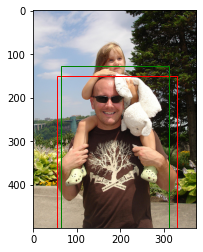

In [75]:
example_img = IMAGE_DIR + "%s.jpg" % dummy_val_image_list[1]
print(example_img)

plt.imshow(Image.open(example_img))

# plt.gca().add_patch(Rectangle((54,151),331-54,500-151,linewidth=1,edgecolor='r',facecolor='none'))
plt.gca().add_patch(Rectangle((54,151),277,349,linewidth=1,edgecolor='r',facecolor='none'))
# plt.gca().add_patch(Rectangle((188 - (249/2),315-(375/2)),249,375,linewidth=1,edgecolor='g',facecolor='none'))
plt.gca().add_patch(Rectangle((64, 128),249,375,linewidth=1,edgecolor='g',facecolor='none'))


# Define IoU

In [77]:
def intersection_over_union(gt_box, pred_box):
    inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection
    
    iou = intersection / union

    return iou, intersection, union


# intersection_over_union([54, 151, 331-54,500-151], [188 - (249/2), 315-(375/2),249,375])

intersection_over_union([54,151,277,349], [64, 128,249,375])

(0.8424966310217457, 86901, 103147)

# Define mAP

In [81]:
precision_list = []

eval_total_t0 = time.time()
    
for clss in classes:
    
    TP, FP, FN = 0, 0, 0

    for img_id in val_image_list:

        gt_dict = load_ground_truth(img_id)[clss]
        pred_dict = preds_map[img_id][clss]        

        gt_map_pred = defaultdict()
        
        for gt_idx, gt_box in enumerate(gt_dict):
            found_gt = False

            for pred_idx, pred_box in enumerate(pred_dict):
  
                iou_score, _, _ = intersection_over_union(pred_box, gt_box)

                if (iou_score >= THRESH_IOU) and (gt_map_pred.get(gt_idx) == None):
                    found_gt = True
                    gt_map_pred[gt_idx] = pred_idx
                    break
                    
                elif (iou_score >= THRESH_IOU) and (gt_map_pred.get(gt_idx) != None):
                    FP += 1
                    
            if found_gt:
                TP += 1
            else:
                FN += 1
        
                
        if len(pred_dict) > len(gt_dict):
            FP += len(pred_dict) - len(gt_dict)
        
    clss_precision = TP / (FP + TP)
    print("precision for class %s : " % clss, clss_precision)
    precision_list.append(clss_precision)    
        
print("Total time took {:} (h:mm:ss) for {} evaluating number of images".format(format_time(time.time() - eval_total_t0), len(val_image_list)))



precision for class aeroplane :  0.9969418960244648
precision for class bicycle :  0.9890510948905109
precision for class bird :  0.9975490196078431
precision for class boat :  0.9678714859437751
precision for class bottle :  0.9483282674772037
precision for class bus :  0.9778761061946902
precision for class car :  0.9746268656716418
precision for class cat :  0.996309963099631
precision for class chair :  0.9666666666666667
precision for class cow :  0.9759615384615384
precision for class diningtable :  0.9067357512953368
precision for class dog :  0.9925595238095238
precision for class horse :  0.9896551724137931
precision for class motorbike :  0.9920948616600791
precision for class person :  0.9755062050947093
precision for class pottedplant :  0.9622641509433962
precision for class sheep :  0.9688473520249221
precision for class sofa :  0.946524064171123
precision for class train :  0.9795081967213115
precision for class tvmonitor :  0.9526813880126183
Total time took 0:00:12 (h:

In [82]:
mean_average_precision = sum(precision_list) / len(precision_list)
print("mean Average Precision across %s : " % len(precision_list), mean_average_precision)

mean Average Precision across 20 :  0.9728779785092388


# YOLO-v2

# prediction time: 0:02:14 (h:mm:ss) for 5105 images
# mean_average_precision: 0.9729
# evaluation time: 0:00:12 (h:mm:ss) for 5105 images

# Do above for Tiny-YOLO

In [85]:
net = load_net(b"cfg/yolov2-tiny-voc.cfg", b"yolov2-tiny-voc.weights", 0)
meta = load_meta(b"cfg/voc.data")
r = detect(net, meta, b"data/dog.jpg")
print(r)

[(b'dog', 0.7836664319038391, (216.7544403076172, 393.0237121582031, 256.93585205078125, 325.7980651855469)), (b'car', 0.5504213571548462, (502.99591064453125, 114.58039855957031, 115.98053741455078, 95.33751678466797)), (b'car', 0.5050010085105896, (560.6170654296875, 130.3031005859375, 217.85064697265625, 131.02023315429688))]


# Predict on Tiny YOLO2

In [86]:
tiny_yolo2_outputs_all = defaultdict()

time_list = []
time_formatted_list = []

total_t0 = time.time()

for idx, img_name in enumerate(val_image_list):
    t0 = time.time()
    
    img_path = os.path.join(IMAGE_DIR, "%s.jpg" % img_name)
    img_path = bytes(img_path, 'utf-8')
    
    r = detect(net, meta, img_path)
    tiny_yolo2_outputs_all[img_name] = r
        
    t1 = time.time() - t0
    t1f = format_time(t1)
    time_list.append(t1)
    time_formatted_list.append(t1f)
    
    if idx % 500 == 0: print("Finished : ", idx)

        
print("Total time took {:} (h:mm:ss) for {} number of images".format(format_time(time.time() - total_t0), len(val_image_list)))

Finished :  0
Finished :  500
Finished :  1000
Finished :  1500
Finished :  2000
Finished :  2500
Finished :  3000
Finished :  3500
Finished :  4000
Finished :  4500
Finished :  5000
Total time took 0:01:48 (h:mm:ss) for 5105 number of images


In [87]:
time_list[:10], time_formatted_list[:10]

([0.061249494552612305,
  0.02295684814453125,
  0.024051427841186523,
  0.02530837059020996,
  0.023323774337768555,
  0.024182796478271484,
  0.02357196807861328,
  0.026470661163330078,
  0.023108243942260742,
  0.0204010009765625],
 ['0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00',
  '0:00:00'])

In [88]:
tiny_yolo_preds_map = defaultdict()

pred_class_set = set()

for img_id, yolo_res in tiny_yolo2_outputs_all.items():
    
    pred_class_objs_map = defaultdict(list)
    
    for obj in yolo_res:
        clss_name = obj[0].decode("utf-8") 
        bbox = obj[2] # [X, Y, width, height]

        reformatted_box = [bbox[0] - int(bbox[2]/2), bbox[1] - int(bbox[3]/2), bbox[2], bbox[3]]
        pred_class_objs_map[clss_name].append(reformatted_box)
        pred_class_set.add(clss_name)
    
    tiny_yolo_preds_map[img_id] = pred_class_objs_map
    
# 2008_000223
pred_class_set, len(pred_class_set)

({'aeroplane',
  'bicycle',
  'bird',
  'boat',
  'bottle',
  'bus',
  'car',
  'cat',
  'chair',
  'cow',
  'diningtable',
  'dog',
  'horse',
  'motorbike',
  'person',
  'pottedplant',
  'sheep',
  'sofa',
  'train',
  'tvmonitor'},
 20)

# Apply mAP on Tiny YOLO

In [89]:
tiny_yolo_precision_list = []

eval_total_t0 = time.time()
    
for clss in classes:
    
    TP, FP, FN = 0, 0, 0

    for img_id in val_image_list:

        gt_dict = load_ground_truth(img_id)[clss]
        pred_dict = tiny_yolo_preds_map[img_id][clss]        

        gt_map_pred = defaultdict()
        
        for gt_idx, gt_box in enumerate(gt_dict):
            found_gt = False

            for pred_idx, pred_box in enumerate(pred_dict):
  
                iou_score, _, _ = intersection_over_union(pred_box, gt_box)

                if (iou_score >= THRESH_IOU) and (gt_map_pred.get(gt_idx) == None):
                    found_gt = True
                    gt_map_pred[gt_idx] = pred_idx
                    break
                    
                elif (iou_score >= THRESH_IOU) and (gt_map_pred.get(gt_idx) != None):
                    FP += 1
                    
            if found_gt:
                TP += 1
            else:
                FN += 1
        
                
        if len(pred_dict) > len(gt_dict):
            FP += len(pred_dict) - len(gt_dict)
        
    clss_precision = TP / (FP + TP)
    print("precision for class %s : " % clss, clss_precision)
    tiny_yolo_precision_list.append(clss_precision)    
        
print("Total time took {:} (h:mm:ss) for {} evaluating number of images".format(format_time(time.time() - eval_total_t0), len(val_image_list)))




precision for class aeroplane :  0.9862385321100917
precision for class bicycle :  0.9887640449438202
precision for class bird :  0.9919354838709677
precision for class boat :  0.9680851063829787
precision for class bottle :  0.9754098360655737
precision for class bus :  0.9868421052631579
precision for class car :  0.9699453551912568
precision for class cat :  0.9868421052631579
precision for class chair :  0.9628378378378378
precision for class cow :  0.9716312056737588
precision for class diningtable :  0.9344262295081968
precision for class dog :  0.9883177570093458
precision for class horse :  0.9906542056074766
precision for class motorbike :  1.0
precision for class person :  0.9850993377483444
precision for class pottedplant :  0.9514563106796117
precision for class sheep :  0.9790575916230366
precision for class sofa :  0.9532710280373832
precision for class train :  0.9925373134328358
precision for class tvmonitor :  0.9314285714285714
Total time took 0:00:13 (h:mm:ss) for 51

In [90]:
tiny_yolo_mean_average_precision = sum(tiny_yolo_precision_list) / len(tiny_yolo_precision_list)
print("mean Average Precision across %s : " % len(tiny_yolo_precision_list), tiny_yolo_mean_average_precision)

mean Average Precision across 20 :  0.9747389978838706


# Tiny-YOLO-v2

# prediction time: 0:01:48 (h:mm:ss) for 5105 images
# mean_average_precision: 0.9747
# evaluation time: 0:00:13 (h:mm:ss) for 5105 images

In [ ]:
# with open("observations.txt", 'w') as f:
#     f.write("YOLO-v2")
    